In [20]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

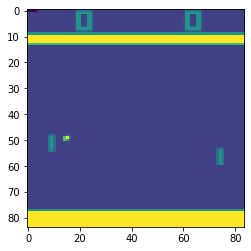

In [21]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [22]:

class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)

class ICM(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(ICM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
                
        self.pred_module1 = nn.Linear(512 + num_actions, 256)
        self.pred_module2 = nn.Linear(256, 512)
            
        self.invpred_module1 = nn.Linear(512 + 512, 256)
        self.invpred_module2 = nn.Linear(256, num_actions)

    def get_feature(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return x
    
    def forward(self, x):
        # get feature
        feature_x = self.get_feature(x)
        return feature_x
    
    def get_full(self, x, x_next, a_vec):
        # get feature
        feature_x = self.get_feature(x)
        feature_x_next = self.get_feature(x_next)

        pred_s_next = self.pred(feature_x, a_vec) # predict next state feature
        pred_a_vec = self.invpred(feature_x, feature_x_next) # (inverse) predict action

        return pred_s_next, pred_a_vec, feature_x_next

    def pred(self, feature_x, a_vec):
        # Forward prediction: predict next state feature, given current state feature and action (one-hot)
        pred_s_next = F.relu(self.pred_module1( torch.cat([feature_x, a_vec.float()], dim = -1).detach()))
        pred_s_next = self.pred_module2(pred_s_next)
        return pred_s_next
    
    def invpred(self,feature_x, feature_x_next):
        # Inverse prediction: predict action (one-hot), given current and next state features
        pred_a_vec = F.relu(self.invpred_module1(torch.cat([feature_x, feature_x_next], dim = -1)))
        pred_a_vec = self.invpred_module2(pred_a_vec)
        return F.softmax(pred_a_vec, dim = -1)


In [23]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [24]:
class ICM_DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4, 
                 forward_scale = 0.8, inverse_scale = 0.2, Qloss_scale = 0.1, intrinsic_scale= 1, use_extrinsic = True):
        self.epsilon = epsilon
        self.action_space = action_space
        # param for ICM
        self.forward_scale = forward_scale # scale for loss function of forward prediction model, 0.8        
        self.inverse_scale = inverse_scale # scale for loss function of inverse prediction model, 0.2
        self.Qloss_scale = Qloss_scale # scale for loss function of Q value, 1
        self.intrinsic_scale = intrinsic_scale # scale for intrinsic reward, 1
        self.use_extrinsic = use_extrinsic # whether use extrinsic rewards, if False, only intrinsic reward generated from ICM is used
        
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())
        self.ICM = ICM(in_channels = in_channels, num_actions = action_space.n)
        
        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
            self.ICM = self.ICM.cuda()
        self.optimizer = optim.Adam(list(self.DQN.parameters())+list(self.ICM.parameters()),lr=lr)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).type(torch.bool)  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)
        
        # get ICM results
        a_vec = F.one_hot(actions, num_classes = self.action_space.n) # convert action from int to one-hot format
        pred_s_next, pred_a_vec, feature_x_next = self.ICM.get_full(states, next_states, a_vec)
        # calculate forward prediction and inverse prediction loss
        forward_loss = F.mse_loss(pred_s_next, feature_x_next.detach(), reduction='none')
        inverse_pred_loss = F.cross_entropy(pred_a_vec, actions.detach(), reduction='none')
        
        # calculate rewards
        intrinsic_rewards = self.intrinsic_scale * forward_loss.mean(-1)
        total_rewards = intrinsic_rewards.clone()
        if self.use_extrinsic:
            total_rewards += rewards
            
        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE
        
        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = total_rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, total_rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        Q_loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())
        loss = self.Qloss_scale*Q_loss + self.forward_scale*forward_loss.mean() + self.inverse_scale* inverse_pred_loss.mean()

        return loss, Q_loss.item(), forward_loss.mean().item(), inverse_pred_loss.mean().item(), intrinsic_rewards.mean().item()
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss, Q_loss, forward_loss, inverse_pred_loss,intrinsic_rewards = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in list(self.DQN.parameters())+list(self.ICM.parameters()):
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item(),Q_loss, forward_loss, inverse_pred_loss,intrinsic_rewards)
        else:
            return(0,0,0,0,0)
    

In [26]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 50000
frames = 1000000
USE_CUDA = True
learning_rate = 1e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 5000 # 10000
win_reward = 18     # Pong-v4
win_break = True

# param for ICM
forward_scale = 1 # scale for loss function of forward prediction model, 0.8        
inverse_scale = 1 # scale for loss function of inverse prediction model, 0.2
Qloss_scale = 1 # scale for loss function of Q value, 1
intrinsic_scale = 100 # scale for intrinsic reward, 1
use_extrinsic = True # whether use extrinsic rewards, if False, only intrinsic reward generated from ICM is used


action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = ICM_DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate,
                    forward_scale = forward_scale, inverse_scale =inverse_scale, Qloss_scale = Qloss_scale, intrinsic_scale= intrinsic_scale,
                     use_extrinsic = use_extrinsic)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "ICM_DQN3_Pong", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])
loss = 0
Q_loss_record = 0
forward_loss_record=0
inverse_pred_loss_record=0
intrinsic_rewards_rec = 0
for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    if agent.memory_buffer.size() >= learning_start:
        loss, Q_loss_record, forward_loss_record, inverse_pred_loss_record, intrinsic_rewards_rec = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, total_loss: %4f, forward_loss: %4f, inverse_pred_loss: %4f, Q_loss: %4f, intrinsic_rewards: %4f, epsilon: %5f, episode: %4d" % 
              (i, np.mean(all_rewards[-10:]), loss, forward_loss_record, inverse_pred_loss_record, Q_loss_record, intrinsic_rewards_rec, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

frames:     0, reward:   nan, total_loss: 0.000000, forward_loss: 0.000000, inverse_pred_loss: 0.000000, Q_loss: 0.000000, intrinsic_rewards: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -21.000000, total_loss: 0.000000, forward_loss: 0.000000, inverse_pred_loss: 0.000000, Q_loss: 0.000000, intrinsic_rewards: 0.000000, epsilon: 0.980397, episode:    1
frames:  2000, reward: -21.000000, total_loss: 0.000000, forward_loss: 0.000000, inverse_pred_loss: 0.000000, Q_loss: 0.000000, intrinsic_rewards: 0.000000, epsilon: 0.961182, episode:    2
frames:  3000, reward: -20.333333, total_loss: 0.000000, forward_loss: 0.000000, inverse_pred_loss: 0.000000, Q_loss: 0.000000, intrinsic_rewards: 0.000000, epsilon: 0.942347, episode:    3
frames:  4000, reward: -20.000000, total_loss: 0.000000, forward_loss: 0.000000, inverse_pred_loss: 0.000000, Q_loss: 0.000000, intrinsic_rewards: 0.000000, epsilon: 0.923885, episode:    4
frames:  5000, reward: -20.000000, total_loss: 1.818037

frames: 44000, reward: -19.500000, total_loss: 1.778721, forward_loss: 0.000000, inverse_pred_loss: 1.776430, Q_loss: 0.002292, intrinsic_rewards: 0.000006, epsilon: 0.420635, episode:   46
frames: 45000, reward: -19.600000, total_loss: 1.787947, forward_loss: 0.000000, inverse_pred_loss: 1.786723, Q_loss: 0.001223, intrinsic_rewards: 0.000041, epsilon: 0.412504, episode:   47
frames: 46000, reward: -19.800000, total_loss: 1.792390, forward_loss: 0.000000, inverse_pred_loss: 1.788144, Q_loss: 0.004245, intrinsic_rewards: 0.000023, epsilon: 0.404534, episode:   48
frames: 47000, reward: -19.700000, total_loss: 1.766752, forward_loss: 0.000000, inverse_pred_loss: 1.764675, Q_loss: 0.002076, intrinsic_rewards: 0.000011, epsilon: 0.396722, episode:   49
frames: 48000, reward: -20.000000, total_loss: 1.800201, forward_loss: 0.000000, inverse_pred_loss: 1.791832, Q_loss: 0.008369, intrinsic_rewards: 0.000015, epsilon: 0.389064, episode:   50
frames: 49000, reward: -20.000000, total_loss: 1.7

frames: 88000, reward: -17.200000, total_loss: 1.772214, forward_loss: 0.000001, inverse_pred_loss: 1.767942, Q_loss: 0.004271, intrinsic_rewards: 0.000052, epsilon: 0.180324, episode:   76
frames: 89000, reward: -17.100000, total_loss: 1.767155, forward_loss: 0.000000, inverse_pred_loss: 1.765419, Q_loss: 0.001737, intrinsic_rewards: 0.000013, epsilon: 0.176952, episode:   77
frames: 90000, reward: -17.100000, total_loss: 1.777267, forward_loss: 0.000000, inverse_pred_loss: 1.774771, Q_loss: 0.002496, intrinsic_rewards: 0.000005, epsilon: 0.173646, episode:   77
frames: 91000, reward: -17.100000, total_loss: 1.759823, forward_loss: 0.000000, inverse_pred_loss: 1.758573, Q_loss: 0.001250, intrinsic_rewards: 0.000003, epsilon: 0.170405, episode:   78
frames: 92000, reward: -17.100000, total_loss: 1.761452, forward_loss: 0.000000, inverse_pred_loss: 1.759375, Q_loss: 0.002077, intrinsic_rewards: 0.000015, epsilon: 0.167229, episode:   78
frames: 93000, reward: -17.300000, total_loss: 1.8

frames: 131000, reward: -14.400000, total_loss: 1.790152, forward_loss: 0.000000, inverse_pred_loss: 1.783965, Q_loss: 0.006186, intrinsic_rewards: 0.000015, epsilon: 0.082075, episode:   95
frames: 132000, reward: -14.200000, total_loss: 1.785104, forward_loss: 0.000000, inverse_pred_loss: 1.783713, Q_loss: 0.001391, intrinsic_rewards: 0.000004, epsilon: 0.080648, episode:   96
frames: 133000, reward: -14.200000, total_loss: 1.811727, forward_loss: 0.000000, inverse_pred_loss: 1.810951, Q_loss: 0.000776, intrinsic_rewards: 0.000011, epsilon: 0.079249, episode:   96
frames: 134000, reward: -14.100000, total_loss: 1.783053, forward_loss: 0.000000, inverse_pred_loss: 1.781816, Q_loss: 0.001236, intrinsic_rewards: 0.000004, epsilon: 0.077878, episode:   97
frames: 135000, reward: -14.100000, total_loss: 1.771201, forward_loss: 0.000000, inverse_pred_loss: 1.770101, Q_loss: 0.001099, intrinsic_rewards: 0.000004, epsilon: 0.076533, episode:   97
frames: 136000, reward: -14.100000, total_los

frames: 174000, reward: -14.500000, total_loss: 1.791556, forward_loss: 0.000000, inverse_pred_loss: 1.790742, Q_loss: 0.000814, intrinsic_rewards: 0.000003, epsilon: 0.040499, episode:  111
frames: 175000, reward: -14.500000, total_loss: 1.798676, forward_loss: 0.000000, inverse_pred_loss: 1.798123, Q_loss: 0.000553, intrinsic_rewards: 0.000002, epsilon: 0.039895, episode:  111
frames: 176000, reward: -14.200000, total_loss: 1.764437, forward_loss: 0.000000, inverse_pred_loss: 1.763243, Q_loss: 0.001193, intrinsic_rewards: 0.000004, epsilon: 0.039303, episode:  112
frames: 177000, reward: -14.200000, total_loss: 1.800273, forward_loss: 0.000000, inverse_pred_loss: 1.799220, Q_loss: 0.001053, intrinsic_rewards: 0.000001, epsilon: 0.038723, episode:  112
frames: 178000, reward: -14.200000, total_loss: 1.790330, forward_loss: 0.000000, inverse_pred_loss: 1.789276, Q_loss: 0.001054, intrinsic_rewards: 0.000001, epsilon: 0.038154, episode:  112
frames: 179000, reward: -13.200000, total_los

frames: 217000, reward: -8.600000, total_loss: 1.788790, forward_loss: 0.000000, inverse_pred_loss: 1.787504, Q_loss: 0.001286, intrinsic_rewards: 0.000001, epsilon: 0.022906, episode:  125
frames: 218000, reward: -8.600000, total_loss: 1.794479, forward_loss: 0.000000, inverse_pred_loss: 1.793330, Q_loss: 0.001148, intrinsic_rewards: 0.000000, epsilon: 0.022651, episode:  125
frames: 219000, reward: -8.600000, total_loss: 1.765303, forward_loss: 0.000000, inverse_pred_loss: 1.764317, Q_loss: 0.000985, intrinsic_rewards: 0.000001, epsilon: 0.022400, episode:  125
frames: 220000, reward: -7.000000, total_loss: 1.766065, forward_loss: 0.000000, inverse_pred_loss: 1.765090, Q_loss: 0.000974, intrinsic_rewards: 0.000002, epsilon: 0.022155, episode:  126
frames: 221000, reward: -7.000000, total_loss: 1.813326, forward_loss: 0.000000, inverse_pred_loss: 1.812648, Q_loss: 0.000678, intrinsic_rewards: 0.000001, epsilon: 0.021914, episode:  126
frames: 222000, reward: -7.200000, total_loss: 1.7

frames: 261000, reward: -6.500000, total_loss: 1.777654, forward_loss: 0.000000, inverse_pred_loss: 1.775996, Q_loss: 0.001658, intrinsic_rewards: 0.000001, epsilon: 0.015353, episode:  138
frames: 262000, reward: -6.900000, total_loss: 1.745703, forward_loss: 0.000000, inverse_pred_loss: 1.744492, Q_loss: 0.001211, intrinsic_rewards: 0.000003, epsilon: 0.015247, episode:  139
frames: 263000, reward: -6.900000, total_loss: 1.791533, forward_loss: 0.000000, inverse_pred_loss: 1.790675, Q_loss: 0.000858, intrinsic_rewards: 0.000001, epsilon: 0.015143, episode:  139
frames: 264000, reward: -6.900000, total_loss: 1.756275, forward_loss: 0.000000, inverse_pred_loss: 1.754711, Q_loss: 0.001565, intrinsic_rewards: 0.000001, epsilon: 0.015042, episode:  139
frames: 265000, reward: -6.900000, total_loss: 1.771787, forward_loss: 0.000000, inverse_pred_loss: 1.771319, Q_loss: 0.000468, intrinsic_rewards: 0.000001, epsilon: 0.014942, episode:  139
frames: 266000, reward: -7.800000, total_loss: 1.7

frames: 305000, reward: -6.200000, total_loss: 1.789591, forward_loss: 0.000000, inverse_pred_loss: 1.789016, Q_loss: 0.000575, intrinsic_rewards: 0.000002, epsilon: 0.012220, episode:  151
frames: 306000, reward: -6.200000, total_loss: 1.728986, forward_loss: 0.000000, inverse_pred_loss: 1.728540, Q_loss: 0.000446, intrinsic_rewards: 0.000001, epsilon: 0.012176, episode:  151
frames: 307000, reward: -5.500000, total_loss: 1.780451, forward_loss: 0.000000, inverse_pred_loss: 1.779760, Q_loss: 0.000691, intrinsic_rewards: 0.000001, epsilon: 0.012133, episode:  152
frames: 308000, reward: -5.500000, total_loss: 1.814164, forward_loss: 0.000000, inverse_pred_loss: 1.813649, Q_loss: 0.000516, intrinsic_rewards: 0.000001, epsilon: 0.012091, episode:  152
frames: 309000, reward: -5.500000, total_loss: 1.765638, forward_loss: 0.000000, inverse_pred_loss: 1.764798, Q_loss: 0.000841, intrinsic_rewards: 0.000002, epsilon: 0.012050, episode:  152
frames: 310000, reward: -5.600000, total_loss: 1.7

frames: 349000, reward: -3.300000, total_loss: 1.741904, forward_loss: 0.000000, inverse_pred_loss: 1.741125, Q_loss: 0.000779, intrinsic_rewards: 0.000002, epsilon: 0.010921, episode:  165
frames: 350000, reward: -3.300000, total_loss: 1.831304, forward_loss: 0.000000, inverse_pred_loss: 1.830678, Q_loss: 0.000626, intrinsic_rewards: 0.000001, epsilon: 0.010903, episode:  165
frames: 351000, reward: -2.100000, total_loss: 1.761817, forward_loss: 0.000000, inverse_pred_loss: 1.760885, Q_loss: 0.000931, intrinsic_rewards: 0.000001, epsilon: 0.010885, episode:  166
frames: 352000, reward: -2.100000, total_loss: 1.765632, forward_loss: 0.000000, inverse_pred_loss: 1.765103, Q_loss: 0.000530, intrinsic_rewards: 0.000001, epsilon: 0.010867, episode:  166
frames: 353000, reward: -2.100000, total_loss: 1.752459, forward_loss: 0.000000, inverse_pred_loss: 1.750868, Q_loss: 0.001591, intrinsic_rewards: 0.000002, epsilon: 0.010850, episode:  166
frames: 354000, reward: -1.200000, total_loss: 1.7

frames: 393000, reward: 6.200000, total_loss: 1.779951, forward_loss: 0.000000, inverse_pred_loss: 1.779468, Q_loss: 0.000483, intrinsic_rewards: 0.000003, epsilon: 0.010382, episode:  179
frames: 394000, reward: 7.200000, total_loss: 1.839373, forward_loss: 0.000000, inverse_pred_loss: 1.837721, Q_loss: 0.001652, intrinsic_rewards: 0.000006, epsilon: 0.010374, episode:  180
frames: 395000, reward: 7.200000, total_loss: 1.797602, forward_loss: 0.000000, inverse_pred_loss: 1.796190, Q_loss: 0.001412, intrinsic_rewards: 0.000001, epsilon: 0.010367, episode:  180
frames: 396000, reward: 7.200000, total_loss: 1.780483, forward_loss: 0.000000, inverse_pred_loss: 1.780157, Q_loss: 0.000326, intrinsic_rewards: 0.000001, epsilon: 0.010360, episode:  180
frames: 397000, reward: 8.800000, total_loss: 1.794863, forward_loss: 0.000000, inverse_pred_loss: 1.794314, Q_loss: 0.000550, intrinsic_rewards: 0.000001, epsilon: 0.010353, episode:  181
frames: 398000, reward: 8.800000, total_loss: 1.779760,

frames: 437000, reward: 14.400000, total_loss: 1.784516, forward_loss: 0.000000, inverse_pred_loss: 1.783893, Q_loss: 0.000622, intrinsic_rewards: 0.000001, epsilon: 0.010158, episode:  200
frames: 438000, reward: 14.400000, total_loss: 1.738479, forward_loss: 0.000000, inverse_pred_loss: 1.738197, Q_loss: 0.000281, intrinsic_rewards: 0.000002, epsilon: 0.010155, episode:  200
frames: 439000, reward: 14.500000, total_loss: 1.751054, forward_loss: 0.000000, inverse_pred_loss: 1.750443, Q_loss: 0.000611, intrinsic_rewards: 0.000001, epsilon: 0.010152, episode:  201
frames: 440000, reward: 14.500000, total_loss: 1.756575, forward_loss: 0.000000, inverse_pred_loss: 1.756406, Q_loss: 0.000169, intrinsic_rewards: 0.000000, epsilon: 0.010149, episode:  201
frames: 441000, reward: 14.200000, total_loss: 1.740761, forward_loss: 0.000000, inverse_pred_loss: 1.740248, Q_loss: 0.000513, intrinsic_rewards: 0.000000, epsilon: 0.010146, episode:  202
frames: 442000, reward: 14.200000, total_loss: 1.8

frames: 481000, reward: 16.200000, total_loss: 1.837844, forward_loss: 0.000000, inverse_pred_loss: 1.837255, Q_loss: 0.000589, intrinsic_rewards: 0.000001, epsilon: 0.010066, episode:  221
frames: 482000, reward: 16.200000, total_loss: 1.829274, forward_loss: 0.000000, inverse_pred_loss: 1.829071, Q_loss: 0.000203, intrinsic_rewards: 0.000000, epsilon: 0.010064, episode:  221
frames: 483000, reward: 15.700000, total_loss: 1.781961, forward_loss: 0.000000, inverse_pred_loss: 1.781581, Q_loss: 0.000380, intrinsic_rewards: 0.000001, epsilon: 0.010063, episode:  222
frames: 484000, reward: 15.700000, total_loss: 1.838534, forward_loss: 0.000000, inverse_pred_loss: 1.838321, Q_loss: 0.000213, intrinsic_rewards: 0.000000, epsilon: 0.010062, episode:  222
frames: 485000, reward: 16.000000, total_loss: 1.755851, forward_loss: 0.000000, inverse_pred_loss: 1.755481, Q_loss: 0.000369, intrinsic_rewards: 0.000001, epsilon: 0.010061, episode:  223
frames: 486000, reward: 16.000000, total_loss: 1.8

frames: 525000, reward: 17.900000, total_loss: 1.791449, forward_loss: 0.000000, inverse_pred_loss: 1.791301, Q_loss: 0.000148, intrinsic_rewards: 0.000000, epsilon: 0.010027, episode:  242
frames: 526000, reward: 17.200000, total_loss: 1.779116, forward_loss: 0.000000, inverse_pred_loss: 1.778844, Q_loss: 0.000272, intrinsic_rewards: 0.000000, epsilon: 0.010027, episode:  243
frames: 527000, reward: 17.200000, total_loss: 1.792431, forward_loss: 0.000000, inverse_pred_loss: 1.792243, Q_loss: 0.000188, intrinsic_rewards: 0.000000, epsilon: 0.010026, episode:  244
frames: 528000, reward: 17.200000, total_loss: 1.789570, forward_loss: 0.000000, inverse_pred_loss: 1.789410, Q_loss: 0.000160, intrinsic_rewards: 0.000000, epsilon: 0.010026, episode:  244
frames: 529000, reward: 17.400000, total_loss: 1.788007, forward_loss: 0.000000, inverse_pred_loss: 1.787845, Q_loss: 0.000162, intrinsic_rewards: 0.000000, epsilon: 0.010025, episode:  245
frames: 530000, reward: 17.400000, total_loss: 1.7

frames: 569000, reward: 16.400000, total_loss: 1.754086, forward_loss: 0.000000, inverse_pred_loss: 1.753810, Q_loss: 0.000275, intrinsic_rewards: 0.000000, epsilon: 0.010011, episode:  264
frames: 570000, reward: 16.000000, total_loss: 1.744100, forward_loss: 0.000000, inverse_pred_loss: 1.743999, Q_loss: 0.000100, intrinsic_rewards: 0.000000, epsilon: 0.010011, episode:  265
frames: 571000, reward: 16.000000, total_loss: 1.792853, forward_loss: 0.000000, inverse_pred_loss: 1.792666, Q_loss: 0.000186, intrinsic_rewards: 0.000000, epsilon: 0.010011, episode:  265
frames: 572000, reward: 16.100000, total_loss: 1.771085, forward_loss: 0.000000, inverse_pred_loss: 1.770827, Q_loss: 0.000257, intrinsic_rewards: 0.000000, epsilon: 0.010011, episode:  266
frames: 573000, reward: 16.100000, total_loss: 1.776825, forward_loss: 0.000000, inverse_pred_loss: 1.776706, Q_loss: 0.000119, intrinsic_rewards: 0.000000, epsilon: 0.010010, episode:  266
frames: 574000, reward: 16.000000, total_loss: 1.7

frames: 613000, reward: 18.700000, total_loss: 1.744048, forward_loss: 0.000000, inverse_pred_loss: 1.743914, Q_loss: 0.000133, intrinsic_rewards: 0.000000, epsilon: 0.010005, episode:  288
frames: 614000, reward: 18.700000, total_loss: 1.747671, forward_loss: 0.000000, inverse_pred_loss: 1.747358, Q_loss: 0.000312, intrinsic_rewards: 0.000000, epsilon: 0.010005, episode:  288
frames: 615000, reward: 17.700000, total_loss: 1.770988, forward_loss: 0.000000, inverse_pred_loss: 1.770046, Q_loss: 0.000942, intrinsic_rewards: 0.000000, epsilon: 0.010005, episode:  289
frames: 616000, reward: 17.700000, total_loss: 1.778439, forward_loss: 0.000000, inverse_pred_loss: 1.778303, Q_loss: 0.000136, intrinsic_rewards: 0.000000, epsilon: 0.010004, episode:  289
frames: 617000, reward: 17.200000, total_loss: 1.769890, forward_loss: 0.000000, inverse_pred_loss: 1.769537, Q_loss: 0.000352, intrinsic_rewards: 0.000000, epsilon: 0.010004, episode:  290
frames: 618000, reward: 17.200000, total_loss: 1.8

frames: 657000, reward: 17.400000, total_loss: 1.776552, forward_loss: 0.000000, inverse_pred_loss: 1.776353, Q_loss: 0.000199, intrinsic_rewards: 0.000000, epsilon: 0.010002, episode:  310
frames: 658000, reward: 17.100000, total_loss: 1.790858, forward_loss: 0.000000, inverse_pred_loss: 1.790702, Q_loss: 0.000156, intrinsic_rewards: 0.000000, epsilon: 0.010002, episode:  311
frames: 659000, reward: 18.200000, total_loss: 1.746806, forward_loss: 0.000000, inverse_pred_loss: 1.746667, Q_loss: 0.000140, intrinsic_rewards: 0.000000, epsilon: 0.010002, episode:  312
frames: 660000, reward: 18.200000, total_loss: 1.782716, forward_loss: 0.000000, inverse_pred_loss: 1.782554, Q_loss: 0.000162, intrinsic_rewards: 0.000000, epsilon: 0.010002, episode:  312
frames: 661000, reward: 18.200000, total_loss: 1.769652, forward_loss: 0.000000, inverse_pred_loss: 1.769362, Q_loss: 0.000290, intrinsic_rewards: 0.000000, epsilon: 0.010002, episode:  312
frames: 662000, reward: 17.700000, total_loss: 1.7

KeyboardInterrupt: 

In [ ]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)

In [23]:
?F.cross_entropy